# An exploration of drivers + their rides

Split rides into a per week basis

In [392]:
# Necessary libs
import os
import numpy as np
import pandas as pd
import scipy
import sklearn
import datetime
from sklearn.linear_model import LinearRegression
from natsort import natsorted


# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import dabest

# custom libs
import sys
sys.path.append("../")
from src.data.rider import Fare, Ride

# Import magic commands for jupyter notebook 
# - autoreloading a module
# - profiling functions for memory usage and scripts
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [324]:
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

driver_ids = pd.read_csv('../data/raw/driver_ids.csv')
ride_ids = pd.read_csv('../data/interim/ride_ids_v2.csv')
ride_timestamps = pd.read_csv('../data/interim/ride_timestamps_v2.csv')

In [325]:
display(driver_ids.head(3))
display(ride_ids.head(3))
display(ride_timestamps.head(3))

,driver_id,driver_onboard_date
0,002be0ffdc997bd5c50703158b7c2491,2016-03-29 00:00:00
1,007f0389f9c7b03ef97098422f902e62,2016-03-29 00:00:00
2,011e5c5dfc5c2c92501b8b24d47509bc,2016-04-05 00:00:00


,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,ride_distance_miles,ride_duration_mins,fare_total,mile_perc,time_perc,lyft_rev,pre_pt_fare,pre_pt_lyft_rev,is_prime_time
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,0.5,1.125303,5.450000,7.489648,0.5191,0.4809,0.4986,6.243099,1.248620,True
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,3362,809,0.0,2.089050,13.483333,9.118741,0.4475,0.5525,1.0737,9.118741,1.823748,False
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,3282,572,0.0,2.039340,9.533333,8.192575,0.5279,0.4721,0.8885,8.192575,1.638515,False


,ride_id,event,timestamp,time_of_day,weekday,month,date,week_index
0,092ec855c70d70df6d4be5fb23e29081,accepted_at,2016-03-29 11:26:43,2,0.0,3,2016-03-29,1
1,a36318bb575fd2e0adefe8a9d5ecf5b3,accepted_at,2016-03-31 10:53:00,2,0.0,3,2016-03-31,1
2,a36318bb575fd2e0adefe8a9d5ecf5b3,arrived_at,2016-03-31 10:57:20,2,0.0,3,2016-03-31,1


# Merge Dataframes together

- rides and fare details w/ event timestamps w/ driver onboarding

In [326]:
nride_df = pd.merge(ride_ids, ride_timestamps, on="ride_id")
nride_df["timestamp"] = pd.to_datetime(nride_df["timestamp"])
nride_df['day_of_week'] = nride_df['timestamp'].dt.day_name()
display(nride_df.head())

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,ride_distance_miles,ride_duration_mins,fare_total,mile_perc,time_perc,lyft_rev,pre_pt_fare,pre_pt_lyft_rev,is_prime_time,event,timestamp,time_of_day,weekday,month,date,week_index,day_of_week
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,0.5,1.125303,5.45,7.489648,0.5191,0.4809,0.4986,6.243099,1.24862,True,dropped_off_at,2016-04-23 02:22:07,1,1.0,4,2016-04-23,4,Saturday
1,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,0.5,1.125303,5.45,7.489648,0.5191,0.4809,0.4986,6.243099,1.24862,True,requested_at,2016-04-23 02:13:50,1,1.0,4,2016-04-23,4,Saturday
2,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,0.5,1.125303,5.45,7.489648,0.5191,0.4809,0.4986,6.243099,1.24862,True,accepted_at,2016-04-23 02:14:15,1,1.0,4,2016-04-23,4,Saturday
3,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,0.5,1.125303,5.45,7.489648,0.5191,0.4809,0.4986,6.243099,1.24862,True,arrived_at,2016-04-23 02:16:36,1,1.0,4,2016-04-23,4,Saturday
4,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,0.5,1.125303,5.45,7.489648,0.5191,0.4809,0.4986,6.243099,1.24862,True,picked_up_at,2016-04-23 02:16:40,1,1.0,4,2016-04-23,4,Saturday


In [327]:
nride_df = nride_df.merge(driver_ids, how="left", on="driver_id")
display(nride_df.head())
display(nride_df.info())

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,ride_distance_miles,ride_duration_mins,fare_total,mile_perc,time_perc,lyft_rev,pre_pt_fare,pre_pt_lyft_rev,is_prime_time,event,timestamp,time_of_day,weekday,month,date,week_index,day_of_week,driver_onboard_date
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,0.5,1.125303,5.45,7.489648,0.5191,0.4809,0.4986,6.243099,1.24862,True,dropped_off_at,2016-04-23 02:22:07,1,1.0,4,2016-04-23,4,Saturday,2016-03-29 00:00:00
1,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,0.5,1.125303,5.45,7.489648,0.5191,0.4809,0.4986,6.243099,1.24862,True,requested_at,2016-04-23 02:13:50,1,1.0,4,2016-04-23,4,Saturday,2016-03-29 00:00:00
2,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,0.5,1.125303,5.45,7.489648,0.5191,0.4809,0.4986,6.243099,1.24862,True,accepted_at,2016-04-23 02:14:15,1,1.0,4,2016-04-23,4,Saturday,2016-03-29 00:00:00
3,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,0.5,1.125303,5.45,7.489648,0.5191,0.4809,0.4986,6.243099,1.24862,True,arrived_at,2016-04-23 02:16:36,1,1.0,4,2016-04-23,4,Saturday,2016-03-29 00:00:00
4,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,0.5,1.125303,5.45,7.489648,0.5191,0.4809,0.4986,6.243099,1.24862,True,picked_up_at,2016-04-23 02:16:40,1,1.0,4,2016-04-23,4,Saturday,2016-03-29 00:00:00


<class 'pandas.core.frame.DataFrame'>
Int64Index: 924076 entries, 0 to 924075
Data columns (total 23 columns):
driver_id              924076 non-null object
ride_id                924076 non-null object
ride_distance          924076 non-null int64
ride_duration          924076 non-null int64
ride_prime_time        924076 non-null float64
ride_distance_miles    924076 non-null float64
ride_duration_mins     924076 non-null float64
fare_total             924076 non-null float64
mile_perc              924076 non-null float64
time_perc              924076 non-null float64
lyft_rev               924076 non-null float64
pre_pt_fare            924076 non-null float64
pre_pt_lyft_rev        924076 non-null float64
is_prime_time          924076 non-null bool
event                  924076 non-null object
timestamp              924076 non-null datetime64[ns]
time_of_day            924076 non-null int64
weekday                924076 non-null float64
month                  924076 non-null int64
dat

None

In [328]:
display(nride_df.describe())

,ride_distance,ride_duration,ride_prime_time,ride_distance_miles,ride_duration_mins,fare_total,mile_perc,time_perc,lyft_rev,pre_pt_fare,pre_pt_lyft_rev,time_of_day,weekday,month,week_index
count,924076.000000,924076.000000,924076.000000,924076.000000,924076.000000,924076.000000,924076.000000,924076.000000,924076.000000,924076.000000,924076.000000,924076.000000,924076.000000,924076.000000,924076.000000
mean,6941.331939,859.691592,0.173839,4.313144,14.328193,13.225883,0.550278,0.449722,1.629445,11.896006,2.379201,2.953158,0.290053,5.150029,8.234397
std,8931.732175,572.528985,0.308425,5.549921,9.542150,9.713683,0.112641,0.112641,1.623859,8.043881,1.608776,1.011761,0.453787,0.754407,3.180603
min,-2.000000,2.000000,0.000000,-0.001243,0.033333,5.120000,0.012900,0.121000,0.274000,5.120000,1.024000,1.000000,0.000000,3.000000,1.000000
25%,2456.000000,492.000000,0.000000,1.526088,8.200000,7.877196,0.472500,0.383000,0.735600,7.427888,1.485578,2.000000,0.000000,5.000000,6.000000
50%,4005.000000,727.000000,0.000000,2.488592,12.116667,10.257384,0.533500,0.466500,1.133100,9.415349,1.883070,3.000000,0.000000,5.000000,8.000000
75%,7166.000000,1070.000000,0.250000,4.452746,17.833333,14.576133,0.617000,0.527500,1.817900,12.839619,2.567924,4.000000,1.000000,6.000000,11.000000
max,724679.000000,28204.000000,5.000000,450.294654,470.066667,400.000000,0.879000,0.987100,124.250700,400.000000,80.000000,4.000000,1.000000,6.000000,13.000000


In [329]:
nride_df["timestamp"] = pd.to_datetime(nride_df["timestamp"])
nride_df["driver_onboard_date"] = pd.to_datetime(nride_df["driver_onboard_date"])
display(nride_df.head(2))

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,ride_distance_miles,ride_duration_mins,fare_total,mile_perc,time_perc,lyft_rev,pre_pt_fare,pre_pt_lyft_rev,is_prime_time,event,timestamp,time_of_day,weekday,month,date,week_index,day_of_week,driver_onboard_date
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,0.5,1.125303,5.45,7.489648,0.5191,0.4809,0.4986,6.243099,1.24862,True,dropped_off_at,2016-04-23 02:22:07,1,1.0,4,2016-04-23,4,Saturday,2016-03-29
1,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,0.5,1.125303,5.45,7.489648,0.5191,0.4809,0.4986,6.243099,1.24862,True,requested_at,2016-04-23 02:13:50,1,1.0,4,2016-04-23,4,Saturday,2016-03-29


In [330]:
# compute time since onboard
nride_df["time_since_onboard"] = nride_df["timestamp"] - nride_df["driver_onboard_date"]
nride_df["days_since_onboard"] = nride_df["time_since_onboard"].dt.days
nride_df["weeks_since_onboard"] = nride_df["time_since_onboard"].dt.days // 7
print(nride_df["time_since_onboard"].dtype)
display(nride_df.head())

timedelta64[ns]


,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,ride_distance_miles,ride_duration_mins,fare_total,mile_perc,time_perc,lyft_rev,pre_pt_fare,pre_pt_lyft_rev,is_prime_time,event,timestamp,time_of_day,weekday,month,date,week_index,day_of_week,driver_onboard_date,time_since_onboard,days_since_onboard,weeks_since_onboard
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,0.5,1.125303,5.45,7.489648,0.5191,0.4809,0.4986,6.243099,1.24862,True,dropped_off_at,2016-04-23 02:22:07,1,1.0,4,2016-04-23,4,Saturday,2016-03-29,25 days 02:22:07,25.0,3.0
1,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,0.5,1.125303,5.45,7.489648,0.5191,0.4809,0.4986,6.243099,1.24862,True,requested_at,2016-04-23 02:13:50,1,1.0,4,2016-04-23,4,Saturday,2016-03-29,25 days 02:13:50,25.0,3.0
2,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,0.5,1.125303,5.45,7.489648,0.5191,0.4809,0.4986,6.243099,1.24862,True,accepted_at,2016-04-23 02:14:15,1,1.0,4,2016-04-23,4,Saturday,2016-03-29,25 days 02:14:15,25.0,3.0
3,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,0.5,1.125303,5.45,7.489648,0.5191,0.4809,0.4986,6.243099,1.24862,True,arrived_at,2016-04-23 02:16:36,1,1.0,4,2016-04-23,4,Saturday,2016-03-29,25 days 02:16:36,25.0,3.0
4,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,0.5,1.125303,5.45,7.489648,0.5191,0.4809,0.4986,6.243099,1.24862,True,picked_up_at,2016-04-23 02:16:40,1,1.0,4,2016-04-23,4,Saturday,2016-03-29,25 days 02:16:40,25.0,3.0


In [331]:
# compute time since onboard
nride_df["time_until_last_event"] = (nride_df["timestamp"].max() - nride_df["timestamp"]) #(nride_df["timestamp"].max() - nride_df["driver_onboard_date"])
print(nride_df["timestamp"].max())
print(nride_df["time_until_last_event"].dtype)
display(nride_df.head())

2016-06-26 23:59:25
timedelta64[ns]


,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,ride_distance_miles,ride_duration_mins,fare_total,mile_perc,time_perc,lyft_rev,pre_pt_fare,pre_pt_lyft_rev,is_prime_time,event,timestamp,time_of_day,weekday,month,date,week_index,day_of_week,driver_onboard_date,time_since_onboard,days_since_onboard,weeks_since_onboard,time_until_last_event
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,0.5,1.125303,5.45,7.489648,0.5191,0.4809,0.4986,6.243099,1.24862,True,dropped_off_at,2016-04-23 02:22:07,1,1.0,4,2016-04-23,4,Saturday,2016-03-29,25 days 02:22:07,25.0,3.0,64 days 21:37:18
1,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,0.5,1.125303,5.45,7.489648,0.5191,0.4809,0.4986,6.243099,1.24862,True,requested_at,2016-04-23 02:13:50,1,1.0,4,2016-04-23,4,Saturday,2016-03-29,25 days 02:13:50,25.0,3.0,64 days 21:45:35
2,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,0.5,1.125303,5.45,7.489648,0.5191,0.4809,0.4986,6.243099,1.24862,True,accepted_at,2016-04-23 02:14:15,1,1.0,4,2016-04-23,4,Saturday,2016-03-29,25 days 02:14:15,25.0,3.0,64 days 21:45:10
3,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,0.5,1.125303,5.45,7.489648,0.5191,0.4809,0.4986,6.243099,1.24862,True,arrived_at,2016-04-23 02:16:36,1,1.0,4,2016-04-23,4,Saturday,2016-03-29,25 days 02:16:36,25.0,3.0,64 days 21:42:49
4,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,0.5,1.125303,5.45,7.489648,0.5191,0.4809,0.4986,6.243099,1.24862,True,picked_up_at,2016-04-23 02:16:40,1,1.0,4,2016-04-23,4,Saturday,2016-03-29,25 days 02:16:40,25.0,3.0,64 days 21:42:45


In [332]:
def compute_last_ride(df):
    # last timestamps for each driver
    last_ts = df.groupby("driver_id")["timestamp"].transform("max") #max()
    return last_ts
last_ts = compute_last_ride(nride_df)

def compute_time_to_last_ride(df):
#     df.groupby("driver_id")["timestamp"].transform(lambda x: last_ts - x)
    return df.groupby('driver_id').timestamp.transform('max') - df.timestamp
    

# df['diff'] = df.groupby('customer_id') \
#                         ['action_date'] \
#                         .transform(lambda x: (x.max()-x.min()).days)
nride_df["timestamp"] = pd.to_datetime(nride_df["timestamp"])
nride_df["time_until_last_ride"] = compute_time_to_last_ride(nride_df)
display(nride_df.head())

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,ride_distance_miles,ride_duration_mins,fare_total,mile_perc,time_perc,lyft_rev,pre_pt_fare,pre_pt_lyft_rev,is_prime_time,event,timestamp,time_of_day,weekday,month,date,week_index,day_of_week,driver_onboard_date,time_since_onboard,days_since_onboard,weeks_since_onboard,time_until_last_event,time_until_last_ride
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,0.5,1.125303,5.45,7.489648,0.5191,0.4809,0.4986,6.243099,1.24862,True,dropped_off_at,2016-04-23 02:22:07,1,1.0,4,2016-04-23,4,Saturday,2016-03-29,25 days 02:22:07,25.0,3.0,64 days 21:37:18,61 days 08:07:46
1,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,0.5,1.125303,5.45,7.489648,0.5191,0.4809,0.4986,6.243099,1.24862,True,requested_at,2016-04-23 02:13:50,1,1.0,4,2016-04-23,4,Saturday,2016-03-29,25 days 02:13:50,25.0,3.0,64 days 21:45:35,61 days 08:16:03
2,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,0.5,1.125303,5.45,7.489648,0.5191,0.4809,0.4986,6.243099,1.24862,True,accepted_at,2016-04-23 02:14:15,1,1.0,4,2016-04-23,4,Saturday,2016-03-29,25 days 02:14:15,25.0,3.0,64 days 21:45:10,61 days 08:15:38
3,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,0.5,1.125303,5.45,7.489648,0.5191,0.4809,0.4986,6.243099,1.24862,True,arrived_at,2016-04-23 02:16:36,1,1.0,4,2016-04-23,4,Saturday,2016-03-29,25 days 02:16:36,25.0,3.0,64 days 21:42:49,61 days 08:13:17
4,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,0.5,1.125303,5.45,7.489648,0.5191,0.4809,0.4986,6.243099,1.24862,True,picked_up_at,2016-04-23 02:16:40,1,1.0,4,2016-04-23,4,Saturday,2016-03-29,25 days 02:16:40,25.0,3.0,64 days 21:42:45,61 days 08:13:13


In [333]:
print(nride_df.shape)

nride_df["weeks_until_last_ride"] = nride_df["time_until_last_ride"].dt.days // 7
nride_df["days_until_last_ride"] = nride_df["time_until_last_ride"].dt.days

display(nride_df.head())

(924076, 28)


,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,ride_distance_miles,ride_duration_mins,fare_total,mile_perc,time_perc,lyft_rev,pre_pt_fare,pre_pt_lyft_rev,is_prime_time,event,timestamp,time_of_day,weekday,month,date,week_index,day_of_week,driver_onboard_date,time_since_onboard,days_since_onboard,weeks_since_onboard,time_until_last_event,time_until_last_ride,weeks_until_last_ride,days_until_last_ride
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,0.5,1.125303,5.45,7.489648,0.5191,0.4809,0.4986,6.243099,1.24862,True,dropped_off_at,2016-04-23 02:22:07,1,1.0,4,2016-04-23,4,Saturday,2016-03-29,25 days 02:22:07,25.0,3.0,64 days 21:37:18,61 days 08:07:46,8,61
1,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,0.5,1.125303,5.45,7.489648,0.5191,0.4809,0.4986,6.243099,1.24862,True,requested_at,2016-04-23 02:13:50,1,1.0,4,2016-04-23,4,Saturday,2016-03-29,25 days 02:13:50,25.0,3.0,64 days 21:45:35,61 days 08:16:03,8,61
2,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,0.5,1.125303,5.45,7.489648,0.5191,0.4809,0.4986,6.243099,1.24862,True,accepted_at,2016-04-23 02:14:15,1,1.0,4,2016-04-23,4,Saturday,2016-03-29,25 days 02:14:15,25.0,3.0,64 days 21:45:10,61 days 08:15:38,8,61
3,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,0.5,1.125303,5.45,7.489648,0.5191,0.4809,0.4986,6.243099,1.24862,True,arrived_at,2016-04-23 02:16:36,1,1.0,4,2016-04-23,4,Saturday,2016-03-29,25 days 02:16:36,25.0,3.0,64 days 21:42:49,61 days 08:13:17,8,61
4,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,0.5,1.125303,5.45,7.489648,0.5191,0.4809,0.4986,6.243099,1.24862,True,picked_up_at,2016-04-23 02:16:40,1,1.0,4,2016-04-23,4,Saturday,2016-03-29,25 days 02:16:40,25.0,3.0,64 days 21:42:45,61 days 08:13:13,8,61


In [203]:
# compute days driven
maxdate = nride_df["timestamp"].max()
mindate = nride_df["timestamp"].min()
nride_df["timestamp"] = pd.to_datetime(nride_df["timestamp"])
nride_df["driver_onboard_date"] = pd.to_datetime(nride_df["driver_onboard_date"])

def compute_days_driven(x):
    x = pd.Series(1, x['timestamp']).resample("D").sum()
    return len(x)

driver_summ_profile = pd.DataFrame()
driver_summ_profile["days_driven"] = nride_df.groupby('driver_id')["timestamp", "driver_onboard_date"].apply(compute_days_driven)

print(driver_summ_profile.shape)
print(driver_summ_profile.head())

(844, 1)
                                  days_driven
driver_id                                    
002be0ffdc997bd5c50703158b7c2491           87
007f0389f9c7b03ef97098422f902e62           86
011e5c5dfc5c2c92501b8b24d47509bc           69
0152a2f305e71d26cc964f8d4411add9           63
01674381af7edd264113d4e6ed55ecda           57


In [204]:
driver_summ_profile = pd.merge(driver_summ_profile, driver_ids, on="driver_id")

driver_summ_profile.set_index("driver_id", inplace=True)

print(driver_summ_profile.shape)
print(driver_summ_profile.head())

(837, 2)
                                  days_driven  driver_onboard_date
driver_id                                                         
002be0ffdc997bd5c50703158b7c2491           87  2016-03-29 00:00:00
007f0389f9c7b03ef97098422f902e62           86  2016-03-29 00:00:00
011e5c5dfc5c2c92501b8b24d47509bc           69  2016-04-05 00:00:00
0152a2f305e71d26cc964f8d4411add9           63  2016-04-23 00:00:00
01674381af7edd264113d4e6ed55ecda           57  2016-04-29 00:00:00


In [205]:
# determine cohort - by "week onboarded" 
nride_df['driver_onboard_date'] = pd.to_datetime(nride_df['driver_onboard_date'])
driver_summ_profile["driver_onboard_date"] = pd.to_datetime(driver_summ_profile['driver_onboard_date'])
print(mindate)
onboard_week = (driver_summ_profile["driver_onboard_date"] - mindate).dt.days // 7 + 1

onboard_week = onboard_week.reset_index(name='week_onboard')

print(driver_summ_profile.shape)
print(driver_summ_profile.head())
print(onboard_week)

2016-03-28 05:48:18
(837, 2)
                                  days_driven driver_onboard_date
driver_id                                                        
002be0ffdc997bd5c50703158b7c2491           87          2016-03-29
007f0389f9c7b03ef97098422f902e62           86          2016-03-29
011e5c5dfc5c2c92501b8b24d47509bc           69          2016-04-05
0152a2f305e71d26cc964f8d4411add9           63          2016-04-23
01674381af7edd264113d4e6ed55ecda           57          2016-04-29
                            driver_id  week_onboard
0    002be0ffdc997bd5c50703158b7c2491             1
1    007f0389f9c7b03ef97098422f902e62             1
2    011e5c5dfc5c2c92501b8b24d47509bc             2
3    0152a2f305e71d26cc964f8d4411add9             4
4    01674381af7edd264113d4e6ed55ecda             5
..                                ...           ...
832  ff419a3476e21e269e340b5f1f05414e             5
833  ff714a67ba8c6a108261cd81e3b77f3a             0
834  fff482c704d36a1afe8b8978d5486283    

In [206]:
driver_summ_profile = driver_summ_profile.merge(onboard_week, how="left", on="driver_id")

print(driver_summ_profile.shape)
print(driver_summ_profile.head())

(837, 4)
                          driver_id  days_driven driver_onboard_date  week_onboard
0  002be0ffdc997bd5c50703158b7c2491           87          2016-03-29             1
1  007f0389f9c7b03ef97098422f902e62           86          2016-03-29             1
2  011e5c5dfc5c2c92501b8b24d47509bc           69          2016-04-05             2
3  0152a2f305e71d26cc964f8d4411add9           63          2016-04-23             4
4  01674381af7edd264113d4e6ed55ecda           57          2016-04-29             5


In [207]:
# compute week_started
def compute_week_started(x):
#     print(x)
    result = (x - mindate).dt.days // 7 + 1
    return result
display(nride_df.head(3))
test = nride_df.groupby(["driver_id", "week_index"])["timestamp"].apply(compute_week_started)
print(test.shape)

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,ride_distance_miles,ride_duration_mins,fare_total,mile_perc,time_perc,lyft_rev,pre_pt_fare,pre_pt_lyft_rev,is_prime_time,event,timestamp,time_of_day,weekday,month,date,week_index,day_of_week,driver_onboard_date,time_since_onboard,days_since_onboard,weeks_since_onboard,time_until_last_event,time_until_last_ride,weeks_until_last_ride,days_until_last_ride
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,0.5,1.125303,5.45,7.489648,0.5191,0.4809,0.4986,6.243099,1.24862,True,dropped_off_at,2016-04-23 02:22:07,1,1.0,4,2016-04-23,4,Saturday,2016-03-29,25 days 02:22:07,25.0,3.0,64 days 21:37:18,61 days 08:07:46,8,61
1,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,0.5,1.125303,5.45,7.489648,0.5191,0.4809,0.4986,6.243099,1.24862,True,requested_at,2016-04-23 02:13:50,1,1.0,4,2016-04-23,4,Saturday,2016-03-29,25 days 02:13:50,25.0,3.0,64 days 21:45:35,61 days 08:16:03,8,61
2,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,0.5,1.125303,5.45,7.489648,0.5191,0.4809,0.4986,6.243099,1.24862,True,accepted_at,2016-04-23 02:14:15,1,1.0,4,2016-04-23,4,Saturday,2016-03-29,25 days 02:14:15,25.0,3.0,64 days 21:45:10,61 days 08:15:38,8,61


(924076,)


In [208]:
# compute week_started
def compute_week_started(x):
    result = (x - mindate).dt.days // 7 + 1
    return result.min()
display(nride_df.head(3))
week_started = nride_df.groupby(["driver_id"])["timestamp"].apply(compute_week_started)

week_started = week_started.reset_index(name="week_start")

driver_summ_profile = driver_summ_profile.merge(week_started, how="left", on="driver_id")
print(driver_summ_profile.shape)
display(driver_summ_profile.head(2))

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,ride_distance_miles,ride_duration_mins,fare_total,mile_perc,time_perc,lyft_rev,pre_pt_fare,pre_pt_lyft_rev,is_prime_time,event,timestamp,time_of_day,weekday,month,date,week_index,day_of_week,driver_onboard_date,time_since_onboard,days_since_onboard,weeks_since_onboard,time_until_last_event,time_until_last_ride,weeks_until_last_ride,days_until_last_ride
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,0.5,1.125303,5.45,7.489648,0.5191,0.4809,0.4986,6.243099,1.24862,True,dropped_off_at,2016-04-23 02:22:07,1,1.0,4,2016-04-23,4,Saturday,2016-03-29,25 days 02:22:07,25.0,3.0,64 days 21:37:18,61 days 08:07:46,8,61
1,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,0.5,1.125303,5.45,7.489648,0.5191,0.4809,0.4986,6.243099,1.24862,True,requested_at,2016-04-23 02:13:50,1,1.0,4,2016-04-23,4,Saturday,2016-03-29,25 days 02:13:50,25.0,3.0,64 days 21:45:35,61 days 08:16:03,8,61
2,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,0.5,1.125303,5.45,7.489648,0.5191,0.4809,0.4986,6.243099,1.24862,True,accepted_at,2016-04-23 02:14:15,1,1.0,4,2016-04-23,4,Saturday,2016-03-29,25 days 02:14:15,25.0,3.0,64 days 21:45:10,61 days 08:15:38,8,61


(837, 5)


,driver_id,days_driven,driver_onboard_date,week_onboard,week_start
0,002be0ffdc997bd5c50703158b7c2491,87,2016-03-29,1,1
1,007f0389f9c7b03ef97098422f902e62,86,2016-03-29,1,1


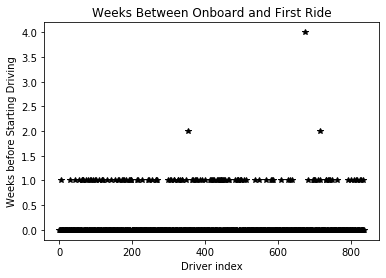

In [191]:
y = driver_summ_profile["week_start"] - driver_summ_profile["week_onboard"]
x = np.arange(len(driver_summ_profile))

fig, ax = plt.subplots(1,1)
ax.plot(x, y, 'k*')
ax.set_xlabel("Driver index")
ax.set_ylabel("Weeks before Starting Driving")
ax.set_title("Weeks Between Onboard and First Ride")
plt.savefig("../reports/figures/weeks_between_onboard_firstride.pdf")

In [210]:
weekinds = natsorted(nride_df["week_index"].unique())

for ind in weekinds:
#     week_df = nride_df[nride_df["week_index"] == ind]
    week_df = nride_df[nride_df["week_index"] == ind].groupby(["driver_id"])["timestamp"].count()
    
    # turn into a dataframe 
    week_df = week_df.reset_index(name=f"week_{ind}")
    
    # add into driver_summ_profile
    driver_summ_profile = driver_summ_profile.merge(week_df, how="left", on="driver_id")
    driver_summ_profile[f"week_{ind}"].fillna(0, inplace=True)
    print(driver_summ_profile.shape)
    
display(driver_summ_profile.head())

(837, 6)
(837, 7)
(837, 8)
(837, 9)
(837, 10)
(837, 11)
(837, 12)
(837, 13)
(837, 14)
(837, 15)
(837, 16)
(837, 17)
(837, 18)


,driver_id,days_driven,driver_onboard_date,week_onboard,week_start,week_1,week_2,week_3,week_4,week_5,week_6,week_7,week_8,week_9,week_10,week_11,week_12,week_13
0,002be0ffdc997bd5c50703158b7c2491,87,2016-03-29,1,1,130.0,55.0,215.0,145.0,15.0,50.0,15.0,130.0,70.0,175.0,205.0,85.0,95.0
1,007f0389f9c7b03ef97098422f902e62,86,2016-03-29,1,1,5.0,5.0,0.0,25.0,30.0,15.0,0.0,30.0,0.0,25.0,0.0,10.0,10.0
2,011e5c5dfc5c2c92501b8b24d47509bc,69,2016-04-05,2,2,0.0,35.0,20.0,0.0,5.0,25.0,10.0,25.0,25.0,0.0,25.0,0.0,0.0
3,0152a2f305e71d26cc964f8d4411add9,63,2016-04-23,4,5,0.0,0.0,0.0,0.0,125.0,85.0,70.0,0.0,120.0,120.0,125.0,100.0,210.0
4,01674381af7edd264113d4e6ed55ecda,57,2016-04-29,5,5,0.0,0.0,0.0,0.0,25.0,250.0,230.0,180.0,255.0,210.0,200.0,255.0,270.0


#### Save Driver Profile (per week)

In [364]:
driver_summ_profile.to_csv("../data/interim/driver_week_profile.csv", index=False)

In [366]:
print(nride_df.shape)
display(nride_df.head(2))

(924076, 30)


,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,ride_distance_miles,ride_duration_mins,fare_total,mile_perc,time_perc,lyft_rev,pre_pt_fare,pre_pt_lyft_rev,is_prime_time,event,timestamp,time_of_day,weekday,month,date,week_index,day_of_week,driver_onboard_date,time_since_onboard,days_since_onboard,weeks_since_onboard,time_until_last_event,time_until_last_ride,weeks_until_last_ride,days_until_last_ride
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,0.5,1.125303,5.45,7.489648,0.5191,0.4809,0.4986,6.243099,1.24862,True,dropped_off_at,2016-04-23 02:22:07,1,1.0,4,2016-04-23,4,Saturday,2016-03-29,25 days 02:22:07,25.0,3.0,64 days 21:37:18,61 days 08:07:46,8,61
1,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,0.5,1.125303,5.45,7.489648,0.5191,0.4809,0.4986,6.243099,1.24862,True,requested_at,2016-04-23 02:13:50,1,1.0,4,2016-04-23,4,Saturday,2016-03-29,25 days 02:13:50,25.0,3.0,64 days 21:45:35,61 days 08:16:03,8,61


In [367]:
nride_df.to_csv("../data/interim/master_ride.csv", index=False)

# Plot And Determine APL and Weekly Stats

In [234]:
print(nride_df.shape)
display(nride_df.head(3))
display(driver_summ_profile.head(3))

(924076, 30)


,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,ride_distance_miles,ride_duration_mins,fare_total,mile_perc,time_perc,lyft_rev,pre_pt_fare,pre_pt_lyft_rev,is_prime_time,event,timestamp,time_of_day,weekday,month,date,week_index,day_of_week,driver_onboard_date,time_since_onboard,days_since_onboard,weeks_since_onboard,time_until_last_event,time_until_last_ride,weeks_until_last_ride,days_until_last_ride
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,0.5,1.125303,5.45,7.489648,0.5191,0.4809,0.4986,6.243099,1.24862,True,dropped_off_at,2016-04-23 02:22:07,1,1.0,4,2016-04-23,4,Saturday,2016-03-29,25 days 02:22:07,25.0,3.0,64 days 21:37:18,61 days 08:07:46,8,61
1,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,0.5,1.125303,5.45,7.489648,0.5191,0.4809,0.4986,6.243099,1.24862,True,requested_at,2016-04-23 02:13:50,1,1.0,4,2016-04-23,4,Saturday,2016-03-29,25 days 02:13:50,25.0,3.0,64 days 21:45:35,61 days 08:16:03,8,61
2,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,0.5,1.125303,5.45,7.489648,0.5191,0.4809,0.4986,6.243099,1.24862,True,accepted_at,2016-04-23 02:14:15,1,1.0,4,2016-04-23,4,Saturday,2016-03-29,25 days 02:14:15,25.0,3.0,64 days 21:45:10,61 days 08:15:38,8,61


,driver_id,days_driven,driver_onboard_date,week_onboard,week_start,week_1,week_2,week_3,week_4,week_5,week_6,week_7,week_8,week_9,week_10,week_11,week_12,week_13
0,002be0ffdc997bd5c50703158b7c2491,87,2016-03-29,1,1,130.0,55.0,215.0,145.0,15.0,50.0,15.0,130.0,70.0,175.0,205.0,85.0,95.0
1,007f0389f9c7b03ef97098422f902e62,86,2016-03-29,1,1,5.0,5.0,0.0,25.0,30.0,15.0,0.0,30.0,0.0,25.0,0.0,10.0,10.0
2,011e5c5dfc5c2c92501b8b24d47509bc,69,2016-04-05,2,2,0.0,35.0,20.0,0.0,5.0,25.0,10.0,25.0,25.0,0.0,25.0,0.0,0.0


In [287]:
def convert_week_timestamp(df):
    result = df["week_start"].apply(lambda x: minweekdate + dt.timedelta(days=7*(x-1)))
    return result

minweekdate = mindate.date()
print(minweekdate)
driver_summ_profile["week_timestamp"] = driver_summ_profile.pipe(convert_week_timestamp)
   
display(driver_summ_profile.head())

2016-03-28


,driver_id,days_driven,driver_onboard_date,week_onboard,week_start,week_1,week_2,week_3,week_4,week_5,week_6,week_7,week_8,week_9,week_10,week_11,week_12,week_13,week_timestamp
0,002be0ffdc997bd5c50703158b7c2491,87,2016-03-29,1,1,130.0,55.0,215.0,145.0,15.0,50.0,15.0,130.0,70.0,175.0,205.0,85.0,95.0,2016-03-28
1,007f0389f9c7b03ef97098422f902e62,86,2016-03-29,1,1,5.0,5.0,0.0,25.0,30.0,15.0,0.0,30.0,0.0,25.0,0.0,10.0,10.0,2016-03-28
2,011e5c5dfc5c2c92501b8b24d47509bc,69,2016-04-05,2,2,0.0,35.0,20.0,0.0,5.0,25.0,10.0,25.0,25.0,0.0,25.0,0.0,0.0,2016-04-04
3,0152a2f305e71d26cc964f8d4411add9,63,2016-04-23,4,5,0.0,0.0,0.0,0.0,125.0,85.0,70.0,0.0,120.0,120.0,125.0,100.0,210.0,2016-04-25
4,01674381af7edd264113d4e6ed55ecda,57,2016-04-29,5,5,0.0,0.0,0.0,0.0,25.0,250.0,230.0,180.0,255.0,210.0,200.0,255.0,270.0,2016-04-25


In [307]:
unique_drivers_perweek = nride_df.groupby("week_index")["driver_id"].unique() 
num_drivers_perweek = [len(x) for x in unique_drivers_perweek]
print("Number of unique drivers per week:\n", num_drivers_perweek)

print("Avg Unique drivers per week: ", np.mean(num_drivers_perweek), scipy.stats.sem(num_drivers_perweek))

Number of unique drivers per week:
 [127, 261, 355, 454, 528, 617, 669, 629, 604, 594, 565, 533, 517]
Avg Unique drivers per week:  496.38461538461536 44.155253260881025


In [308]:
137.94892593647532 * 496.38

68475.08785634761

# Average Number of Rides Per week

It is quite clear that normalizing by number of unique drivers that week is a better estimate for the number of rides.

Average rides +/- std +/- sem:  71082.76923076923 +/- 28660.110549198995 +/- 7948.884472738721
Average rides +/- std +/- sem:  137.94892593647532 +/- 24.170189507503355 +/- 6.703604431306543


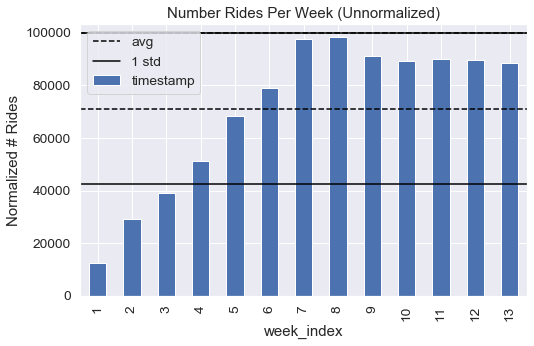

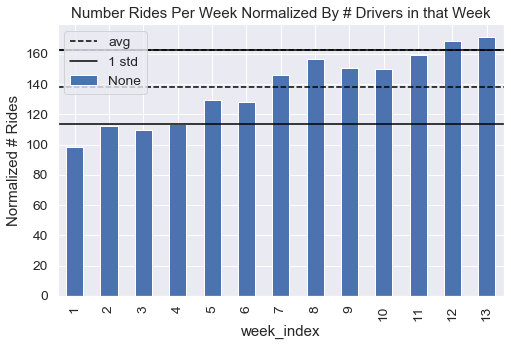

In [306]:
# average rides per week normalized by number of drivers that week
avg_rides_perweek = nride_df.groupby("week_index")["timestamp"].count().mean()
std_rides_perweek = nride_df.groupby("week_index")["timestamp"].count().std()
sem_rides_perweek = nride_df.groupby("week_index")["timestamp"].count().sem()

# average rides per week unnormalized 
sns.set(font_scale=1.25)
fig, ax = plt.subplots(1,1, figsize=(8,5))
nride_df.groupby("week_index")["timestamp"].count().plot(kind="bar", ax=ax)
ax.set_ylabel("Normalized # Rides")
ax.set_title("Number Rides Per Week (Unnormalized)")
ax.axhline(avg_rides_perweek, color="black", linestyle="--")
ax.axhline(avg_rides_perweek+std_rides_perweek, color="black", linestyle="--", label="avg")
ax.axhline(avg_rides_perweek+std_rides_perweek, color="black", linestyle="-")
ax.axhline(avg_rides_perweek-std_rides_perweek, color="black", linestyle="-", label="1 std")
ax.legend()
# plt.savefig("../reports/figures/avg_number_rides_perweek.pdf")
print("Average rides +/- std +/- sem: ",avg_rides_perweek, "+/-", std_rides_perweek, "+/-", sem_rides_perweek)

# average rides per week normalized by number of drivers that week
avg_rides_perweek = nride_df.groupby("week_index")["timestamp"].count().divide(num_drivers_perweek).mean()
std_rides_perweek = nride_df.groupby("week_index")["timestamp"].count().divide(num_drivers_perweek).std()
sem_rides_perweek = nride_df.groupby("week_index")["timestamp"].count().divide(num_drivers_perweek).sem()

sns.set(font_scale=1.25)
fig, ax = plt.subplots(1,1, figsize=(8,5))
nride_df.groupby("week_index")["timestamp"].count().divide(num_drivers_perweek).plot(kind="bar", ax=ax)
ax.set_ylabel("Normalized # Rides")
ax.set_title("Number Rides Per Week Normalized By # Drivers in that Week")
ax.axhline(avg_rides_perweek, color="black", linestyle="--")
ax.axhline(avg_rides_perweek+std_rides_perweek, color="black", linestyle="--", label="avg")
ax.axhline(avg_rides_perweek+std_rides_perweek, color="black", linestyle="-")
ax.axhline(avg_rides_perweek-std_rides_perweek, color="black", linestyle="-", label="1 std")
ax.legend()
plt.savefig("../reports/figures/avg_number_rides_perweek.pdf")

print("Average rides +/- std +/- sem: ",avg_rides_perweek, "+/-", std_rides_perweek, "+/-", sem_rides_perweek)

In [233]:
# get the week indices of rides
week_start = nride_df.groupby("week_index")["timestamp"].min().dt.date

print(week_start_end)

week_index
1     2016-03-28
2     2016-04-04
3     2016-04-11
4     2016-04-18
5     2016-04-25
6     2016-05-02
7     2016-05-09
8     2016-05-16
9     2016-05-23
10    2016-05-30
11    2016-06-06
12    2016-06-13
13    2016-06-20
Name: timestamp, dtype: object


In [288]:
import datetime as dt

### Some useful functions
def add_weeks(sourcedate, weeks):
    return sourcedate + dt.timedelta(days=7*weeks)

def first_day_of_week(sourcedate):
    return sourcedate - dt.timedelta(days = sourcedate.weekday())

def last_day_of_week(sourcedate):
    return sourcedate + dt.timedelta(days=(6 - sourcedate.weekday()))  

def retained_in_interval(users, cohort_start, n_weeks, end_date):
    '''
        For a given list of users, returns the number of users 
        that signed up in the week of signup_week (the cohort)
        and that are retained after n_weeks
        end_date is just here to control that we do not un-necessarily fill the bottom right of the table
    '''
    # Define the span of the given week
    cohort_end         = add_weeks(cohort_start, 1)
    
    # column with datetime of that week
    signup_col = "week_timestamp"
    
    if n_weeks == 0:
        # If this is our first week, we just take the number of users that signed up on the given period of time
        return len( users[(users[signup_col] >= cohort_start) 
                        & (users[signup_col] <= cohort_end)])
    elif pd.to_datetime(add_weeks(cohort_end,n_weeks)) > pd.to_datetime(end_date) :
        # If adding n_weeks brings us later than the end date of the table (the bottom right of the table),
        # We return some easily recognizable date (not 0 as it would cause confusion)
        return float("Inf")
    else:
        # Otherwise, we count the number of users that signed up on the given period of time,
        # and whose last known log was later than the number of weeks added (rolling retention)
        return len( users[(users[signup_col] >= cohort_start) 
                        & (users[signup_col] <= cohort_end)
#                         & pd.to_datetime((users['last_log'])    >=  
#                                          pd.to_datetime(users[signup_col].map(lambda x: add_weeks(x,n_weeks))))
                        ])

In [360]:
def cohort_table(users,cohort_number=13,period_number=13,
                 cohort_span='W',start_date=None,end_date=None):
    '''
        For a given dataframe of users, return a cohort table with the following parameters :
        cohort_number : the number of lines of the table
        period_number : the number of columns of the table
        cohort_span : the span of every period of time between the cohort (D, W, M)
        end_date = the date after which we stop counting the users
    '''
    # the last column of the table will end today :
    if end_date is None:
        end_date = dt.datetime.today()
    if start_date is None:
        start_date = dt.datetime.today()
    # The index of the dataframe will be a list of dates ranging
    dates = pd.date_range(add_weeks(end_date,-cohort_number), periods=cohort_number, freq=cohort_span)
    
    dates = [add_weeks(start_date, i).date() for i in range(period_number)] #, periods=cohort_number, freq=cohort_span)
    dates.append(end_date.date())
#     print(dates)
    
    index_col = 'onboard_ride'
    
    # create cohort dataframe
    cohort = pd.DataFrame(columns=[index_col])
    cohort['onboard_ride'] = dates
    # We will compute the number of retained users, column-by-column
    #      (There probably is a more pythonesque way of doing it)
    range_dates = range(0,period_number+1)
    for p in range_dates:
        # Name of the column
        s_p = f"week_{p}"
        cohort[s_p] = cohort.apply(lambda row: retained_in_interval(users,row[index_col],p,end_date), axis=1)

    cohort = cohort.set_index(index_col)        
    # absolute values to percentage by dividing by the value of week 0 :
#     cohort = cohort.astype('float').div(cohort['week_0'].astype('float'),axis='index')
    return cohort

In [361]:
print(mindate, maxdate)

2016-03-28 05:48:18 2016-06-26 23:59:25


In [362]:
# churn-rate
cohort = cohort_table(driver_summ_profile, cohort_number=13, period_number=13, 
                      cohort_span="W",
                      start_date=mindate,
                      end_date=maxdate)

In [363]:
display(cohort.head())

,week_0,week_1,week_2,week_3,week_4,week_5,week_6,week_7,week_8,week_9,week_10,week_11,week_12,week_13
onboard_ride,,,,,,,,,,,,,,
2016-03-28,275,275.0,275.0,275.0,275.0,275.0,275.0,275.0,275.0,275.0,275.0,275.0,inf,inf
2016-04-04,275,275.0,275.0,275.0,275.0,275.0,275.0,275.0,275.0,275.0,275.0,inf,inf,inf
2016-04-11,247,247.0,247.0,247.0,247.0,247.0,247.0,247.0,247.0,247.0,inf,inf,inf,inf
2016-04-18,232,232.0,232.0,232.0,232.0,232.0,232.0,232.0,232.0,inf,inf,inf,inf,inf
2016-04-25,216,216.0,216.0,216.0,216.0,216.0,216.0,216.0,inf,inf,inf,inf,inf,inf


# Cohort by Week Analysis

In [336]:
print(nride_df.shape)
display(nride_df.head(3))
display(driver_summ_profile.head(3))

(924076, 30)


,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,ride_distance_miles,ride_duration_mins,fare_total,mile_perc,time_perc,lyft_rev,pre_pt_fare,pre_pt_lyft_rev,is_prime_time,event,timestamp,time_of_day,weekday,month,date,week_index,day_of_week,driver_onboard_date,time_since_onboard,days_since_onboard,weeks_since_onboard,time_until_last_event,time_until_last_ride,weeks_until_last_ride,days_until_last_ride
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,0.5,1.125303,5.45,7.489648,0.5191,0.4809,0.4986,6.243099,1.24862,True,dropped_off_at,2016-04-23 02:22:07,1,1.0,4,2016-04-23,4,Saturday,2016-03-29,25 days 02:22:07,25.0,3.0,64 days 21:37:18,61 days 08:07:46,8,61
1,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,0.5,1.125303,5.45,7.489648,0.5191,0.4809,0.4986,6.243099,1.24862,True,requested_at,2016-04-23 02:13:50,1,1.0,4,2016-04-23,4,Saturday,2016-03-29,25 days 02:13:50,25.0,3.0,64 days 21:45:35,61 days 08:16:03,8,61
2,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,0.5,1.125303,5.45,7.489648,0.5191,0.4809,0.4986,6.243099,1.24862,True,accepted_at,2016-04-23 02:14:15,1,1.0,4,2016-04-23,4,Saturday,2016-03-29,25 days 02:14:15,25.0,3.0,64 days 21:45:10,61 days 08:15:38,8,61


,driver_id,days_driven,driver_onboard_date,week_onboard,week_start,week_1,week_2,week_3,week_4,week_5,week_6,week_7,week_8,week_9,week_10,week_11,week_12,week_13,week_timestamp
0,002be0ffdc997bd5c50703158b7c2491,87,2016-03-29,1,1,130.0,55.0,215.0,145.0,15.0,50.0,15.0,130.0,70.0,175.0,205.0,85.0,95.0,2016-03-28
1,007f0389f9c7b03ef97098422f902e62,86,2016-03-29,1,1,5.0,5.0,0.0,25.0,30.0,15.0,0.0,30.0,0.0,25.0,0.0,10.0,10.0,2016-03-28
2,011e5c5dfc5c2c92501b8b24d47509bc,69,2016-04-05,2,2,0.0,35.0,20.0,0.0,5.0,25.0,10.0,25.0,25.0,0.0,25.0,0.0,0.0,2016-04-04


week_start
1    127
2    148
3    127
4    120
5    112
6    104
7     97
8      2
Name: driver_id, dtype: int64
837
119.28571428571429 15.709090050161455


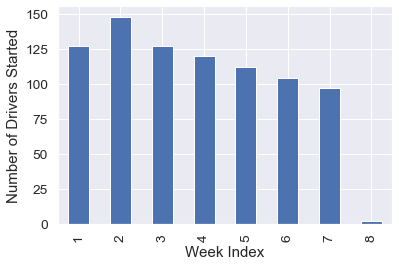

In [418]:
week_cols = [f"week_{i}" for i in range(1, 14)]

cohort_list = driver_summ_profile.groupby("week_start")["driver_id"].count()

fig, ax = plt.subplots(1,1)
driver_summ_profile.groupby("week_start")["driver_id"].count().plot(kind="bar", ax=ax)
ax.set_xlabel("Week Index")
ax.set_ylabel("Number of Drivers Started")
plt.savefig("../reports/figures/number_drivers_start_perweek.pdf")
print(cohort_list)
print(sum(cohort_list))
print(np.mean(cohort_list[:-1]), np.std(cohort_list[:-1]))

In [421]:
# track each cohort over weeks within the dataset
week_cols = [f"week_{i}" for i in range(1, 14)]

cohort_list = []
cohort_hue = []

weekstartinds = sorted(driver_summ_profile["week_start"].unique())
for ind in weekstartinds[:-1]:
    weekstart_df = driver_summ_profile[driver_summ_profile["week_start"] == ind]
    
    week_stats = []
    for col in week_cols:
        result = len(weekstart_df[weekstart_df[col] > 0])
        week_stats.append(result)
    
    cohort_list.append(week_stats)
    cohort_hue.append(ind)
    # number unique drivers
#     unique_drivers = weekstart_df["driver_ids"].unique().count()
# print(cohort_list.shape)
# print(cohort_list)

0.6838842572693652


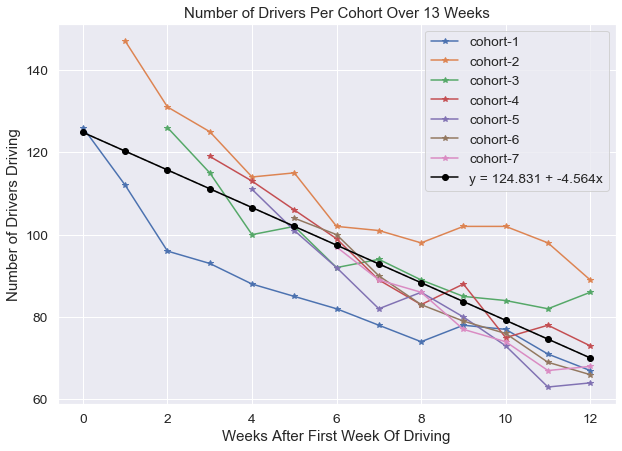

In [429]:
fig, ax = plt.subplots(1,1,figsize=(10,7))
X = []
Y = []
for i in range(len(cohort_hue)):
    cohort_ind = cohort_hue[i]
    x = np.arange(cohort_ind-1, 13).tolist()
#     x = np.arange(0, 14-cohort_ind).tolist()
    y = cohort_list[i][cohort_ind-1:]
    X.extend(x)
    Y.extend(y)
    ax.plot(x, y, '-*', label=f"cohort-{cohort_hue[i]}")
    
lr = LinearRegression()
X = np.array(X)
Y = np.array(Y)
lr.fit(X[:, np.newaxis], Y)  # x needs to be 2d for LinearRegression
x = np.arange(0, 13)
ax.plot(x, lr.predict(x[:, np.newaxis]), linestyle='--')

print(lr.score(X[:, np.newaxis], Y))
coef = np.round(lr.coef_[0], 3)
intercept = np.round(lr.intercept_, 3)

lrstr = f"y = {intercept} + {coef}x" 

ax.plot(x, lr.predict(x[:, np.newaxis]), '-o', color='black', label=lrstr)
ax.set_xlabel("Weeks After First Week Of Driving")
ax.set_ylabel("Number of Drivers Driving")
ax.set_title("Number of Drivers Per Cohort Over 13 Weeks")
ax.legend()
plt.savefig("../reports/figures/cohort_over_time.pdf")

In [414]:
print
print("Average cohort lifetime: ", 119/4.5)

Average cohort lifetime:  26.444444444444443


week_1      14.893668
week_2      34.669056
week_3      46.350060
week_4      61.266428
week_5      81.469534
week_6      93.898447
week_7     116.107527
week_8     117.020311
week_9     108.641577
week_10    106.440860
week_11    107.408602
week_12    106.820789
week_13    105.402628
dtype: float64 week_1      46.828680
week_2      73.583281
week_3      80.998024
week_4      90.555381
week_5     104.948851
week_6     106.519324
week_7     120.001666
week_8     122.120963
week_9     118.659692
week_10    116.331332
week_11    124.040298
week_12    126.908385
week_13    125.790464
dtype: float64


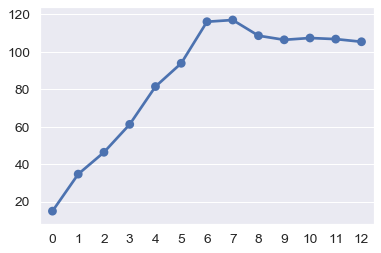

In [320]:
"""
Plot week_1->week_13 with number of rides per week
hue is driver_id

don't show legend
"""
# driver_summ_profile.plot(x="driver_id", )
avg_profile = driver_summ_profile.mean()
std_profile = driver_summ_profile.std()

x = np.arange(0, 13)
ymean = avg_profile[3:]
ystd = std_profile[3:]

# print(ymean, ystd)
fig, ax = plt.subplots(1,1)
# sns.pointplot(x, ymean, yerr=ystd)

In [312]:
avg_weeks_driven = driver_summ_profile["days_driven"].mean()/7

driver_summ_profile["weeks_driven"] = driver_summ_profile["days_driven"]

7.986175115207374


In [420]:
driver_summ_profile.to_csv("../data/interim/driver_week_profile.csv", index=False)

# DLV

In [415]:
print("Average ride value is: ", nride_df["fare_total"].mean() , "+/-", nride_df["fare_total"].std())

print("Average ride value for Lyft is: ", nride_df["lyft_rev"].mean() , "+/-", nride_df["lyft_rev"].std())

Average ride value is:  13.225882700078289 +/- 9.713683009220286
Average ride value for Lyft is:  1.6294447371211895 +/- 1.6238589045767595


In [430]:
print(138*26.44*1.89)
print(138*59*1.89)

6896.0808
15388.38


# Average Ride Value for Lyft

In [416]:
print((13.23 - 2 - 1.75)*0.2)

1.8960000000000001
